In [2]:
import numpy as np
import scipy as sp
from scipy.optimize import fsolve, minimize, root
from torch import autograd, tensor, tensor_split
import torch

In [3]:
####################################################################################################
## example of "backward" from https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html ##
####################################################################################################

a = tensor([2.], requires_grad=True)
b = tensor([4.], requires_grad=True)

obj_fun = 3*a**3 - b**3
# c_eq = 0
c_eq = a**2-b**2
# c_ineq <= 0, to be transformed into bound constraints 
c_ineq = a*b # will be a*b + y = 0, y >= 0

lm_eq = 3
lm_ineq = 1

# transform ineq constraints into eq constraints
lm_bound = 1
slack = tensor([2.], requires_grad=True)
c_ineq_slack = c_ineq + slack

L = obj_fun - lm_eq*torch.cat([c_eq, c_ineq_slack]) - lm_bound*slack
# def L(x, slack): return Q(x) - lm_eq*[c_eq + c_ineq] - lm_bound*slack

external_grad = tensor([1., 1.])
L.backward(gradient=external_grad)

print(a.grad)
print(b.grad)
print(slack.grad)

tensor([48.])
tensor([-78.])
tensor([-5.])


In [4]:
# objective function (minimize)
def obj_fun(x):
    val = (x[0]**2+(x[1]-5)**2)
    return val

# constraints of form g(x) = 0
def c_eq(x):
    # constr = torch.zeros(1,dtype=torch.float64)
    # if constr.ndim == 0:
    #     constr = constr.unsqueeze(dim=0)
    # return constr
    return None

# constraints of form g(x) <= 0
def c_ineq(x):
    constr = torch.cat([
        -1.*x[0].reshape(1),
        -1.*x[1].reshape(1),
        (2*x[0] + x[1] - 4).reshape(1)
    ])
    return constr

# later replace with a normal "all constraints" function
def constraints(x):
    c_eq_eval = c_eq(x)
    c_ineq_eval = torch.relu(c_ineq(x))
    if c_eq_eval is None:
        return c_ineq_eval
    else:
        return torch.concat([c_eq_eval, c_ineq_eval])
    
def lagr(x, l):
    f = obj_fun(x)
    constr = constraints(x)
    return f + l @ constr

def aug_lagr(x, l, ss):
    f = obj_fun(x)
    constr = constraints(x)
    return f + l @ constr + 0.5*ss*torch.sum(torch.square(constr))

def lagr_univar(z, n, m_eq):
    if m_eq > 0:
        x, l = tensor_split(z, (n,))
    else:
        x, l = tensor_split(z, (n,))
    return lagr(x, l)
    

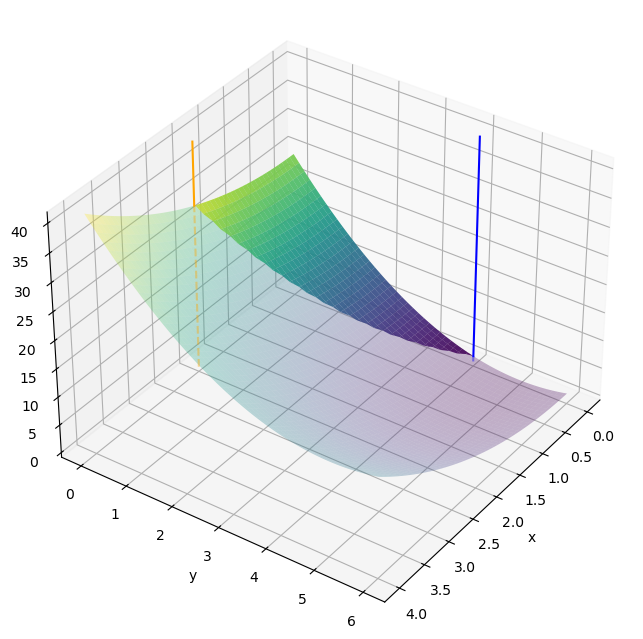

In [5]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Define grid for x and y
x = np.linspace(0, 4, 100)
y = np.linspace(0, 6, 100)
X, Y = np.meshgrid(x, y)

Z = np.array([obj_fun([x, y]) for x, y in zip(X, Y)])
constraint = -2 * X - Y + 4 >= 0

Z_masked = np.where(constraint, Z, np.nan)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z_masked, cmap='viridis', edgecolor='none', alpha=0.9,zorder=-1)
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.3,zorder=-1)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.view_init(35, 35, 0)
ax.plot([2, 2], [0,0], [obj_fun([2,0]), 40],zorder=10, c='orange', label='argmax')
ax.plot([2, 2], [0,0], [0, obj_fun([2,0])],zorder=10, c='orange', ls='--', alpha=0.4)
ax.plot([0, 0], [4,4], [obj_fun([0,4]), 40],zorder=10, c='blue', label='argmin')
ax.plot([0, 0], [4,4], [0, obj_fun([0,4])],zorder=10, c='blue', ls='--', alpha=0.4)

# plt.legend()
# plt.show()

***
Working with autograd functional api (much nicer):

In [6]:
n = 2
m_eq = 0
m_ineq = 3

In [11]:
def lagr_autojac_wrapper(z, numpy=True):
    if not isinstance(z, torch.Tensor):
        z = tensor(z,dtype=torch.float64)
    jac = torch.autograd.functional.jacobian(lambda x: lagr_univar(x,n, m_eq), z)
    if numpy:
        return jac.numpy()
    else:
        return jac

def lagr_autohess_wrapper(z, numpy=True):
    if not isinstance(z, torch.Tensor):
        z = tensor(z,dtype=torch.float64)
    hess = torch.autograd.functional.hessian(lambda x: lagr_univar(x, n, m_eq), z)
    if numpy:
        return hess.numpy()
    else:
        return hess
    
def aug_lagr_autojac_wrapper(z, l, s, numpy=False):
    if not isinstance(z, torch.Tensor):
        z = tensor(z,dtype=torch.float64)
    jac = torch.autograd.functional.jacobian(lambda x: aug_lagr(x, l, s), z)
    if numpy:
        return jac.numpy()
    else:
        return jac

x = torch.ones(n+m_eq+m_ineq, dtype=torch.float64)
print(lagr_autojac_wrapper(x))
print(lagr_autohess_wrapper(x))

[ 2. -8.  0.  0.  0.]
[[2. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


***
Aug lagr method

In [55]:
from torch.autograd.functional import jacobian
from torch.optim import SGD, Adam

x0 = torch.ones(n, dtype=torch.float64, requires_grad=True)
_l = torch.ones(m_eq + m_ineq, dtype=torch.float64)
_ss = 1.01
t = 1.1

_x = x0
opt = Adam([_x], lr=0.005)
# scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=1, gamma=0.9)

for k in range(1000):
    loss = aug_lagr(_x, _l, _ss)
    opt.zero_grad()
    _x.grad = aug_lagr_autojac_wrapper(_x, _l, _ss)

    prev_x = _x.clone()
    prev_l = _l.clone()
    
    opt.step()
    # scheduler.step()
    # sol = minimize(fun = lambda x: aug_lagr(tensor(x), _l, _ss), x0=_x,
    #                jac = lambda x: aug_lagr_autojac_wrapper(x, _l, _ss))
    # update iterates
    _l += _ss*constraints(_x)
    _ss *= t
    # break if no progress
    loss_progress = loss - aug_lagr(_x, _l, _ss)
    # print(loss_progress.item())

    # print(torch.sum(torch.square(constraints(_x))).item())

    if loss_progress < 0:
        _x = prev_x
        _l = prev_l
        _ss /= t
        break

print('n iter:')
print(k)
print('\nx*:')
print(_x)
# print(c_eq(_x))
print("\nInequality constraints, should be <= 0")
print(c_ineq(_x))
print('\nobj fun:')
print(obj_fun(_x))

n iter:
816

x*:
tensor([8.4462e-06, 3.9997e+00], dtype=torch.float64, grad_fn=<CloneBackward0>)

Inequality constraints, should be <= 0
tensor([-8.4462e-06, -3.9997e+00, -2.5952e-04], dtype=torch.float64,
       grad_fn=<CatBackward0>)

obj fun:
tensor(1.0006, dtype=torch.float64, grad_fn=<AddBackward0>)


***
Try to find roots of the (auto)gradient of the lagrangian

...with scipy:

In [16]:
# find a root of gradient (jacobian) of lagrangian

sol = root(lagr_autojac_wrapper, x0=torch.zeros(n+m_ineq,dtype=torch.float64), jac=lagr_autohess_wrapper,
           method='broyden2', options={'maxiter': 5000, 'xtol':1e-12})

print(sol)
print('\n ------\n')
print(f"x = {sol['x']}")
print(f"obj. fun. at x = {obj_fun(sol['x'][:n])}")
print(f"jac. of lagr. at x = {sol['fun']}")
print(f"c_ineq at x = {c_ineq(tensor(sol['x']))}")

 message: A solution was found at the specified tolerance.
 success: True
  status: 1
     fun: [ 8.937e-14  5.707e-14  1.027e-12  2.451e-13  0.000e+00]
       x: [-2.451e-13  4.000e+00  2.000e+00  4.000e+00 -2.051e-01]
     nit: 15
  method: broyden2
    nfev: 57

 ------

x = [-2.45082427e-13  4.00000000e+00  2.00000000e+00  4.00000000e+00
 -2.05128205e-01]
obj. fun. at x = 0.999999999996966
jac. of lagr. at x = [8.93715657e-14 5.70654635e-14 1.02673425e-12 2.45082427e-13
 0.00000000e+00]
c_ineq at x = tensor([ 1.0267e-12,  2.4508e-13, -4.0000e+00], dtype=torch.float64)


c:\Users\andre\miniconda3\envs\tame\lib\site-packages\scipy\optimize\_root.py:255: RuntimeWarning: Method broyden2 does not use the jacobian (jac).
  _warn_jac_unused(jac, method)
c:\Users\andre\miniconda3\envs\tame\lib\site-packages\scipy\optimize\_nonlin.py:992: RuntimeWarning: invalid value encountered in divide
  d = v / df_norm**2


...and again with scipy:

In [9]:
# find roots of gradient (jacobian) of lagrangian
from scipy.optimize import fsolve

sol = fsolve(lagr_autojac_wrapper, x0=torch.ones(n+m_eq+m_ineq,dtype=torch.float64), fprime=lagr_autohess_wrapper)
print(sol)
print(obj_fun(sol))

[-0.03467591  4.08538236 -1.82309656 -3.57243775  1.        ]
0.8377278395861524


C:\Users\andre\AppData\Local\Temp\ipykernel_13580\1552003059.py:4: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  sol = fsolve(lagr_autojac_wrapper, x0=torch.ones(n+m_eq+m_ineq,dtype=torch.float64), fprime=lagr_autohess_wrapper)
